In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
if 'google.colab' in str(get_ipython()): # running in colab
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/revisiting_crossval_RNAfolding/'
else:
    DATA_PATH = '/home/lbugnon/shared_insync/revisiting_crossval_RNAfolding/'

## Ordendanando archivos 
*NO CORRER ESTA SECCION*
- Esta parte la dejo de referencia, ya deje los csvs limpios
- filtro todo para que queden secuencias de longitud < 512, quedan los bkp cualquier cosa, la idea es que el dataset, particiones y predicciones tengan los mismos ids

In [ ]:
!pip install git+https://github.com/lbugnon/sincfold_utils 

Dataset

In [48]:
dataset = pd.read_csv(f"{DATA_PATH}data/archiveII_220808.csv", index_col="id")
print(dataset.shape, dataset.len.max(), dataset.len.min())
dataset = dataset[dataset.len < 512]
dataset = dataset[["sequence", "len", "structure", "base_pairs"]]
print(dataset.shape, dataset.len.max(), dataset.len.min())
dataset.to_csv(f"{DATA_PATH}data/archiveII_250808.csv")
dataset.head()

(3975, 10) 2968 28
(3864, 4) 510 28


,sequence,len,structure,base_pairs
id,,,,
5s_Acholeplasma-laidlawii-1,UCUGGUGACGAUAGGUAAGAUGGUUCACCUGUUCCCAUCCCGAACA...,112,((((((((......((((((((....((((((.............)...,"[[1, 111], [2, 110], [3, 109], [4, 108], [5, 1..."
5s_Acidovorax-temperans-1,UGCCUGAUGACCAUAGCAAGUUGGUACCACUCCUUCCCAUCCCGAA...,115,.(((((((((.....((((((((.....((((((...............,"[[2, 115], [3, 114], [4, 113], [5, 112], [6, 1..."
tmRNA_Stre.gord._TRW-29390_1-349,GGGGUCGUUACGGAUUCGACAGGCAUUAUGAGGCAUAUUUUGCGAC...,349,(((((((............((((((((....(((((((((..((((...,"[[1, 345], [2, 344], [3, 343], [4, 342], [5, 3..."
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,UCCGUUGUGGUCCAACGGCUAGGAUUCGUCGCUUUCACCGACGGGA...,75,(((((((..((((........))))((((((.......)))))).....,"[[1, 71], [2, 70], [3, 69], [4, 68], [5, 67], ..."
srp_List.mono._U15684,UGGGUUGAUGAGCGUGAAGCCUUCGCUCGGUUGGAUUUUUCUUCAU...,279,.(.((((...(.(.((.(.((..(.....)..)).)...(...(.....,"[[2, 276], [4, 274], [5, 273], [6, 272], [7, 2..."


Classical methods

In [42]:
from sincfold_utils.io import dot2bp
for method in ["IPKnot", "LinearFoldV", "LinearPartitionC", "LinearPartitionV", "RNAfold", "RNAstructure"]:
    pred = pd.read_csv(DATA_PATH+f"results/{method}.csv", index_col="id")
    pred = pred.loc[dataset.index]
    if "base_pairs" in pred.columns:
        continue
    if " folding" in pred.columns:
        pred["folding"] = pred[" folding"]
        
    if "dataset_name" in pred.columns:
        pred = pred[pred["dataset_name"]=="archiveII"]    

    pred["base_pairs"] = pred["folding"].apply(dot2bp)
    print(f"Saving {method} with fixed base pairs", pred.shape)
    !mv {DATA_PATH}results/{method}.csv {DATA_PATH}results/bkp_clasical_methods/{method}.csv
    pred[["base_pairs"]].to_csv(f"{DATA_PATH}results/{method}.csv")


Saving IPKnot with fixed base pairs (3864, 3)
Saving LinearFoldV with fixed base pairs (3864, 3)
Saving LinearPartitionC with fixed base pairs (3864, 3)
Saving LinearPartitionV with fixed base pairs (3864, 3)
Saving ProbKnot with fixed base pairs (3864, 4)
Saving RNAfold with fixed base pairs (3864, 3)
Saving RNAstructure with fixed base pairs (3864, 3)


In [76]:
method = "ProbKnot"
pred = pd.read_csv(DATA_PATH+f"results/{method}.csv", index_col="id")
pred = pred.loc[dataset.index]
pred["base_pairs"] = pred.folding    
if "dataset_name" in pred.columns:
    pred = pred[pred["dataset_name"]=="archiveII"]    

!mv {DATA_PATH}results/{method}.csv {DATA_PATH}results/bkp_clasical_methods/{method}.csv
print(f"Saving {method} with fixed base pairs", pred.shape)
pred[["base_pairs"]].to_csv(f"{DATA_PATH}results/{method}.csv")


Saving ProbKnot with fixed base pairs (3864, 4)


Some predictions are missing in some methods, these are filled with an empty prediction to be accountable. Also removing unused colunmns


In [129]:
splits = pd.read_csv(f"{DATA_PATH}data/1_random_kfolds/ArchiveII_splits_random.csv", index_col="id")

for method in ["REDfold"]:
    for fold in sorted(splits.fold_number.unique()):
        split_dataset = splits[(splits.fold_number == fold) & (splits.partition == "test")].index
        pred = pd.read_csv(DATA_PATH+f"results/1_random_kfolds/{method}/{fold}/pred.csv", index_col="id")
        print(fold, pred.shape)
        pred = pred.loc[split_dataset]
        print(pred.shape)
        
        !mkdir -p {DATA_PATH}results/1_random_kfolds/{method}/bkp/{fold}/
        !mv {DATA_PATH}results/1_random_kfolds/{method}/{fold}/pred.csv {DATA_PATH}results/1_random_kfolds/{method}/bkp/{fold}/pred.csv
        pred[["base_pairs"]].to_csv(f"{DATA_PATH}results/1_random_kfolds/{method}/{fold}/pred.csv")
        

0 (773, 3)
(773, 3)
1 (773, 3)
(772, 3)
2 (773, 3)
(773, 3)
3 (773, 3)
(773, 3)
4 (773, 3)
(773, 3)


## Performance

In [77]:
dataset = pd.read_csv(f"{DATA_PATH}data/archiveII_250808.csv", index_col="id")
dataset.head()

,sequence,len,structure,base_pairs
id,,,,
5s_Acholeplasma-laidlawii-1,UCUGGUGACGAUAGGUAAGAUGGUUCACCUGUUCCCAUCCCGAACA...,112,((((((((......((((((((....((((((.............)...,"[[1, 111], [2, 110], [3, 109], [4, 108], [5, 1..."
5s_Acidovorax-temperans-1,UGCCUGAUGACCAUAGCAAGUUGGUACCACUCCUUCCCAUCCCGAA...,115,.(((((((((.....((((((((.....((((((...............,"[[2, 115], [3, 114], [4, 113], [5, 112], [6, 1..."
tmRNA_Stre.gord._TRW-29390_1-349,GGGGUCGUUACGGAUUCGACAGGCAUUAUGAGGCAUAUUUUGCGAC...,349,(((((((............((((((((....(((((((((..((((...,"[[1, 345], [2, 344], [3, 343], [4, 342], [5, 3..."
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,UCCGUUGUGGUCCAACGGCUAGGAUUCGUCGCUUUCACCGACGGGA...,75,(((((((..((((........))))((((((.......)))))).....,"[[1, 71], [2, 70], [3, 69], [4, 68], [5, 67], ..."
srp_List.mono._U15684,UGGGUUGAUGAGCGUGAAGCCUUCGCUCGGUUGGAUUUUUCUUCAU...,279,.(.((((...(.(.((.(.((..(.....)..)).)...(...(.....,"[[2, 276], [4, 274], [5, 273], [6, 272], [7, 2..."


Classical methods are not trained, therefore the score per sequence is the same in all cases

In [ ]:
from sincfold_utils.metrics import bp_metrics

classical_methods = ["IPKnot", "LinearFoldV", "LinearPartitionC", "LinearPartitionV", "ProbKnot", "RNAfold", "RNAstructure"] 

# load predictions and compute f1 scores
summary = []
for method in classical_methods:
    print(method, end=" ")
    pred = pd.read_csv(DATA_PATH+f"results/{method}.csv", index_col="id")
    pred["ref"] = dataset.loc[pred.index, "base_pairs"]
    pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
    pred["method"] = method
    pred = pred[["method", "f1", "rec", "pre"]]
    summary.append(pred)
summary = pd.concat(summary)    
summary.head()

IPKnot LinearFoldV LinearPartitionC LinearPartitionV ProbKnot RNAfold RNAstructure 

,method,f1,rec,pre
id,,,,
5s_Acholeplasma-laidlawii-1,IPKnot,0.620690,0.600000,0.642857
5s_Acidovorax-temperans-1,IPKnot,0.911765,0.939394,0.885714
tmRNA_Stre.gord._TRW-29390_1-349,IPKnot,0.500000,0.474747,0.528090
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,IPKnot,0.650000,0.590909,0.722222
srp_List.mono._U15684,IPKnot,0.797468,0.732558,0.875000


## Random k-fold
- sincfold is running
- ufold TODO

In [130]:
splits = pd.read_csv(f"{DATA_PATH}data/1_random_kfolds/ArchiveII_splits_random.csv", index_col="id")
splits.groupby("fold_number").count()

,partition
fold_number,
0,3864
1,3864
2,3864
3,3864
4,3864


In [139]:
import os
trained_methods = ["MxFold2", "REDfold", "UFold", "sincFold"]

folds = sorted(splits["fold_number"].unique())
kfold_summary = []
for fold in folds:
    partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
    for method in trained_methods:
        f = DATA_PATH+f"results/1_random_kfolds/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(method, fold, f"Not found, skipping")
            continue
        print(method, fold)
        
        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        kfold_summary.append(pred)
kfold_summary = pd.concat(kfold_summary)    
kfold_summary.head()

MxFold2 0
REDfold 0
UFold 0 Not found, skipping
sincFold 0 Not found, skipping
MxFold2 1
REDfold 1
UFold 1 Not found, skipping
sincFold 1 Not found, skipping
MxFold2 2
REDfold 2
UFold 2 Not found, skipping
sincFold 2 Not found, skipping
MxFold2 3
REDfold 3
UFold 3 Not found, skipping
sincFold 3 Not found, skipping
MxFold2 4
REDfold 4
UFold 4 Not found, skipping
sincFold 4 Not found, skipping


,method,fold,f1,rec,pre
id,,,,,
5s_Acidovorax-temperans-1,MxFold2,0,0.939394,0.939394,0.939394
5s_Methanothermobacter-thermautotrophicus-6,MxFold2,0,0.739726,0.750000,0.729730
5s_Saprospira-grandis-1,MxFold2,0,0.969697,0.969697,0.969697
grp1_a.I1.e.P.inouyei.C1.SSU.1506,MxFold2,0,0.649573,0.638655,0.660870
5s_Ralstonia-pickettii-1,MxFold2,0,1.000000,1.000000,1.000000


In [ ]:
# add classical methods to kfold summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
        res = summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        kfold_summary = pd.concat([kfold_summary, res])
kfold_summary.method.unique()        

array(['MxFold2', 'REDfold', 'IPKnot', 'LinearFoldV', 'LinearPartitionC',
       'LinearPartitionV', 'ProbKnot', 'RNAfold', 'RNAstructure'],
      dtype=object)

/tmp/ipykernel_158913/3653410898.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Fold")


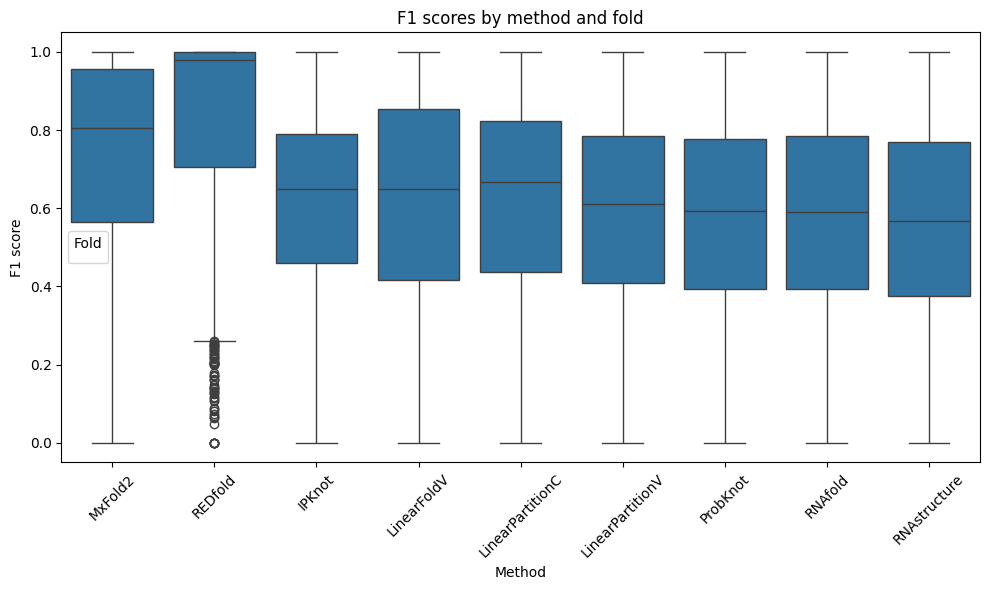

In [146]:
# boxplot methods (to improve)
plt.figure(figsize=(10, 6))
sns.boxplot(data=kfold_summary, x="method", y="f1")
plt.xticks(rotation=45)
plt.title("F1 scores by method and fold")
plt.xlabel("Method")
plt.ylabel("F1 score")
plt.legend(title="Fold")
plt.tight_layout()
